# 파이토치 CIFAR10 모델
- 코드 출처: https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

## modules import

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-white")

- 현재 GPU 설정

In [2]:
torch.cuda.is_available()

True

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
device

device(type='cuda')

## 전처리 설정

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

## 데이터 로드 및 확인

In [6]:
trainset = torchvision.datasets.CIFAR10(root = '/data',
                                        train = True,
                                        download = True,
                                        transform = transform)

testset = torchvision.datasets.CIFAR10(root = '/data',
                                        train = False,
                                        download = True,
                                        transform = transform)

Extracting /data/cifar-10-python.tar.gz to /data
Files already downloaded and verified


In [7]:
train_loader = DataLoader(trainset,
                          batch_size = 4,
                          shuffle = True,
                          num_workers = 2)
test_loader = DataLoader(trainset,
                          batch_size = 4,
                          shuffle = False,
                          num_workers = 2)

In [8]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

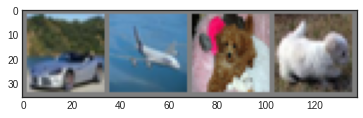

	car 	plane 	dog 	dog


In [13]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(" ".join("\t{}".format(classes[labels[j]]) for j in range(4)))

## 신경망 구성

In [15]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

## 손실함수와 옵티마이저

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum= 0.9)

## 모델 학습

- 설명을 위해 `epochs=2`로 지정

In [17]:
for epoch in range(2):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 2.202778909802437
Epoch: 1, Batch: 4000, Loss: 1.808028642565012
Epoch: 1, Batch: 6000, Loss: 1.646789653390646
Epoch: 1, Batch: 8000, Loss: 1.5474467810988426
Epoch: 1, Batch: 10000, Loss: 1.512268089130521
Epoch: 1, Batch: 12000, Loss: 1.4417907084971666
Epoch: 2, Batch: 2000, Loss: 1.3821199513077735
Epoch: 2, Batch: 4000, Loss: 1.356506222344935
Epoch: 2, Batch: 6000, Loss: 1.3329235253371299
Epoch: 2, Batch: 8000, Loss: 1.2994883837662636
Epoch: 2, Batch: 10000, Loss: 1.2695658572241664
Epoch: 2, Batch: 12000, Loss: 1.2630896067172288


## 모델의 저장 및 로드

In [18]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

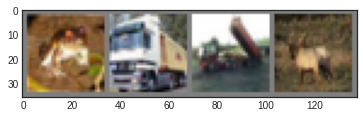

	frog 	truck 	truck 	deer


In [22]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(" ".join('\t{}'.format(classes[labels[j]]) for j in range(4)))

In [23]:
net = Net().to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트

In [24]:
outputs = net(images.to(device))

In [25]:
_, predicted = torch.max(outputs, 1)
print(" ".join("\t{}".format(classes[predicted[j]]) for j in range(4)))

	frog 	ship 	truck 	deer


In [26]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(100 * correct / total)

55.432


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [27]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze() 
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(classes[i], 100 * class_correct[i] / class_total[i]))



Accuracy of plane: 68.24%
Accuracy of car: 65.28%
Accuracy of bird: 41.56%
Accuracy of cat: 39.24%
Accuracy of deer: 46.2%
Accuracy of dog: 23.62%
Accuracy of frog: 70.02%
Accuracy of horse: 57.78%
Accuracy of ship: 80.3%
Accuracy of truck: 62.08%
